In [1]:
import torch
import librosa
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
# @title MusicDataset
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, input_dir, target_dir, sr=22050, duration=30):
        self.data = []
        self.sr = sr
        self.duration = duration
        self.max_length = sr * duration  # Calculate max_length

        # Adjusted to handle files named as mix_i.wav and synth_i.wav
        file_indices = range(150)  # Assuming the range is from 0 to 149

        pbar = tqdm(total=len(file_indices), desc='Loading Data', unit='file')

        for i in file_indices:
            input_file = os.path.join(input_dir, f'mix_{i}.wav')
            target_file = os.path.join(target_dir, f'synth_{i}.wav')

            # Load audio files
            input_audio, _ = librosa.load(input_file, sr=self.sr, duration=self.duration)
            target_audio, _ = librosa.load(target_file, sr=self.sr, duration=self.duration)

            # Pad audio sequences to the same length
            input_audio = self._pad_audio(input_audio, self.max_length)
            target_audio = self._pad_audio(target_audio, self.max_length)

            self.data.append((torch.tensor(input_audio, dtype=torch.float32), 
                              torch.tensor(target_audio, dtype=torch.float32)))

            pbar.update(1)

        pbar.close()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_audio, target_audio = self.data[idx]
        # Add a channel dimension: [sequence_length] -> [1, sequence_length]
        input_audio = input_audio.unsqueeze(0) 
        target_audio = target_audio.unsqueeze(0)
        return input_audio, target_audio


    def _pad_audio(self, audio, max_length):
        padding_length = max_length - len(audio)
        if padding_length > 0:
            return np.pad(audio, (0, padding_length), 'constant')
        return audio


In [2]:
# @title Encoder & Decoder
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_size):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_channels, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Conv1d(hidden_size * 2, hidden_size * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv_layers(x)


class Decoder(nn.Module):
    def __init__(self, input_channels, hidden_size, output_channels):
        super(Decoder, self).__init__()
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose1d(input_channels, hidden_size * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size * 2, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # or ReLU, depending on your data range
        )

    def forward(self, x):
        return self.deconv_layers(x)


class AudioEncoderDecoder(nn.Module):
    def __init__(self, input_channels, hidden_size, output_channels):
        super(AudioEncoderDecoder, self).__init__()
        self.encoder = Encoder(input_channels, hidden_size)
        self.decoder = Decoder(hidden_size * 4, hidden_size, output_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [12]:
# @title Training Loop
def train(model, train_loader, num_epochs, learning_rate, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")

In [4]:
# @title Hyperparameter and Dataset
input_channels = 1  # Mono audio
hidden_size = 64
output_channels = 1  # Mono audio
learning_rate = 0.001
num_epochs = 25
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:


# Load your dataset
input_dir = 'G:\我的云端硬盘\Colab_Notebooks\EE641\mix'
target_dir = 'G:\我的云端硬盘\Colab_Notebooks\EE641\synth'
train_dataset = MusicDataset(input_dir, target_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

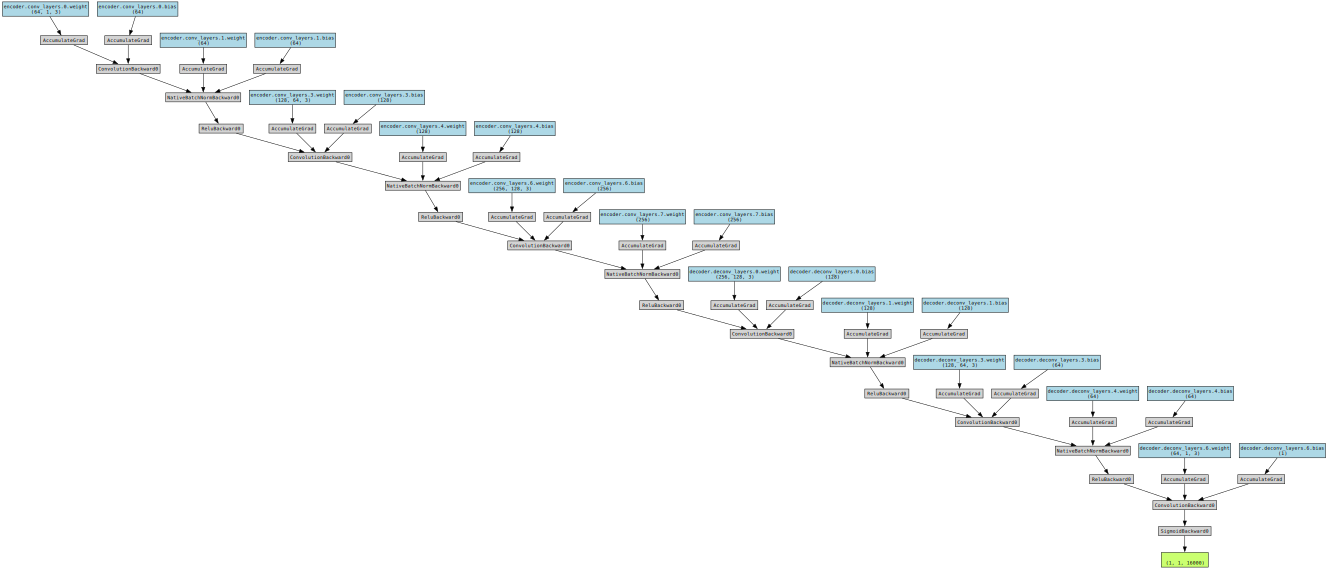

In [9]:
from torchviz import make_dot

batch_size = 1
channels = 1  # Mono audio
audio_length = 16000  # Example length, adjust as needed


x_encoder_decoder = torch.randn(batch_size, channels, audio_length)

# Instantiate the model
model = AudioEncoderDecoder(input_channels, hidden_size, output_channels)

out = model(x_encoder_decoder)

dot = make_dot(out, params=dict(list(model.named_parameters()) + [('x', x_encoder_decoder)]))
dot.attr(rankdir='TB')  # LR for left-to-right, TB for top-to-bottom
# dot.attr(size='10,10')
dot

# Visualize the model
# dot = make_dot(out, params=dict(model.named_parameters()))
# dot.render('./model_architecture', format='png')  # Saves the diagram as 'model_architecture.png'
# dot

In [13]:
# Instantiate the model
model = AudioEncoderDecoder(input_channels, hidden_size, output_channels)

# Train the model
train(model, train_loader, num_epochs, learning_rate, device)

Epoch 1/25:   0%|          | 0/10 [00:00<?, ?batch/s]


RuntimeError: Given groups=1, weight of size [64, 1, 3], expected input[1, 16, 661500] to have 1 channels, but got 16 channels instead